In [2]:
!pip install datasets

In [3]:
!pip install nltk gensim

In [4]:
!pip install wandb

In [5]:
!pip install --upgrade numpy gensim

  Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [ ]:
import gensim.downloader as api

# Load the pre-trained FastText model
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

In [ ]:
# Download tokenizer assets
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from datasets import load_dataset
from nltk.tokenize import word_tokenize
import random
import os

In [ ]:
train_dataset = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid_dataset = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test_dataset = load_dataset("tau/commonsense_qa", split="validation")

In [ ]:
train_dataset = train_dataset.remove_columns(['id', 'question_concept'])
valid_dataset = valid_dataset.remove_columns(['id', 'question_concept'])
test_dataset = test_dataset.remove_columns(['id', 'question_concept'])

In [ ]:
def tokenize(dataset):
    dataset['question'] = nltk.word_tokenize(dataset['question'])
    dataset['choices']['text'] = [nltk.word_tokenize(choice) for choice in dataset['choices']['text']]
    return dataset

train_dataset = train_dataset.map(tokenize)
valid_dataset = valid_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)

In [ ]:
nltk.download('wordnet')
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]
for dataset in [train_dataset, valid_dataset, test_dataset]:
    for example in dataset:
        example['question'] = lemmatize_tokens(example['question']) 

In [ ]:
PART-1 : Word embeddings (fastText) together with a classifier (2-layer with ReLU 
non-linearity).

In [ ]:
def get_embedding(word, model=fasttext_model):
    try:
        return model[word]  # Retrieve the embedding for the word
    except KeyError:
        return np.zeros(300)  # Return a zero vector if the word is not in vocabulary

In [ ]:
def preprocess_data(data):
    processed_data = []

    for item in data:
        question = item['question']
        choices = item['choices']['text']
        answer_key = item['answerKey']
        
        # Compute average embedding for the question
        question_embedding = np.mean([get_embedding(word) for word in question], axis=0)
        
        # Compute average embeddings for each choice
        choice_embeddings = [np.mean([get_embedding(word) for word in choice], axis=0) for choice in choices]
        
        # Concatenate question embedding with each choice embedding
        concatenated_inputs = [np.concatenate([question_embedding, choice_embedding]) for choice_embedding in choice_embeddings]
        
        # Map the answer to a label (A -> 0, B -> 1, ..., E -> 4)
        label = ord(answer_key) - ord('A')  # 'A' maps to 0, 'B' to 1, etc.
        
        processed_data.append({
            'inputs': concatenated_inputs,
            'label': label
        })
    
    return processed_data

processed_train_data_1 = preprocess_data(train_dataset)
print(f"Processed data (example): {processed_train_data_1[1]}")


In [ ]:

# CommonsenseQADataset class for preparing dataset
class CommonsenseQADataset_model1(Dataset):
    def __init__(self, processed_data):
        self.data = processed_data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        inputs = item['inputs']  # List of 5 embeddings
        label = item['label']    # Correct answer's index
        
        # Convert inputs (list of 5 embeddings) into a tensor
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return inputs_tensor, label_tensor

train_dataset = CommonsenseQADataset_model1(processed_train_data_1)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Check shapes for debugging
for inputs, label in train_dataloader:
    print(f"Inputs shape: {inputs.shape}")  # Should be (batch_size, 5, 600)
    print(f"Labels shape: {label.shape}")  # Should be (batch_size,)
    break

In [ ]:
# Classifier model
class ClassifierModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(ClassifierModel, self).__init__()
        # Define the layers of the 2-layer fully connected (FC) network
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Input to hidden layer
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # Hidden to output layer
        
    def forward(self, x):
        # Flatten the input for each sample: (batch_size, 5, 600) -> (batch_size * 5, 600)
        x = x.view(-1, 600)
        # Pass the input through the first hidden layer with ReLU activation
        x = F.relu(self.fc1(x))
        # Pass through the second layer (output layer)
        x = self.fc2(x)
        return x

In [ ]:
import wandb
# Initialize W&B
wandb.init(project='CQA_Model-1', name='train-1', config={
    'epochs': 3,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'hidden_dim': 256,
    'input_dim': 600,
    'num_classes': 5
})

In [ ]:
# Set the model, loss function, and optimizer
model = ClassifierModel(input_dim=600, hidden_dim=256, num_classes=5)
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
loss_fn = nn.CrossEntropyLoss()

# Training loop with W&B tracking
def train_with_wandb(model, dataloader, epochs=3):
    model.train()
    device = next(model.parameters()).device  # Get model's device
    
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_samples = 0
        
        for inputs, labels in dataloader:
            # Move data to model's device
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Reshape and expand
            inputs = inputs.view(-1, 600)  # [batch_size*5, 600]
            expanded_labels = labels.repeat_interleave(5)  # [batch_size*5]
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Loss calculation
            loss = loss_fn(outputs, expanded_labels)
            total_loss += loss.item()
            
            # Accuracy calculation
            outputs = outputs.view(-1, 5, 5)  # [batch_size, 5, 5]
            _, predicted = outputs.max(dim=-1)  # Get predictions per option
            correct = (predicted == labels.unsqueeze(1)).any(dim=1).sum().item()
            
            correct_predictions += correct
            total_samples += labels.size(0)
            
            # Backprop
            loss.backward()
            optimizer.step()
        
        # Epoch metrics
        epoch_loss = total_loss / len(dataloader)
        epoch_acc = correct_predictions / total_samples
        
        wandb.log({'epoch': epoch+1, 'loss': epoch_loss, 'accuracy': epoch_acc})
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

train_with_wandb(model, train_dataloader, epochs=wandb.config.epochs)



In [26]:
wandb.finish()

accuracy,▁▆█
epoch,▁▅█
loss,█▅▁
accuracy,0.38348
epoch,3
loss,1.6071


In [ ]:
processed_valid_data_1 = preprocess_data(valid_dataset)
valid_dataset = CommonsenseQADataset_model1(processed_valid_data_1)  


In [28]:

def validate_model(model, valid_loader):
    model.eval()
    correct, total = 0, 0
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
            
            outputs = model(inputs.view(-1, 600))
            outputs = outputs.view(-1, 5, 5)
            _, predicted = outputs.max(dim=-1)
            correct += (predicted == labels.unsqueeze(1)).any(dim=1).sum().item()
            total += labels.size(0)
    
    return correct / total

In [30]:
!pip install optuna

  Using cached optuna-4.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
Using cached optuna-4.2.1-py3-none-any.whl (383 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)


In [32]:
import optuna

In [35]:
def objective(trial):
    # Hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'hidden_dim': trial.suggest_int('hidden_dim', 128, 512),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    }
    
    # Initialize W&B
    wandb.init(
        project='CQA_Model-1_Optuna',
        name=f'trial_{trial.number}',
        config={
            **params,
            'epochs': 3,
            'input_dim': 600,
            'num_classes': 5
        },
        reinit=True
    )
    
    # Create loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=params['batch_size'],
        shuffle=True,
        pin_memory=True
    )
    
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=params['batch_size'],
        shuffle=False,
        pin_memory=True
    )
    
    # Initialize model
    model = ClassifierModel(
        input_dim=600,
        hidden_dim=params['hidden_dim'],
        num_classes=5
    ).to('cuda')
    
    # Optimizer and loss
    optimizer = optim.Adam(
        model.parameters(),
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    loss_fn = nn.CrossEntropyLoss()
    
    best_val_acc = 0
    
    for epoch in range(3):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to('cuda', non_blocking=True)
            labels = labels.to('cuda', non_blocking=True)
            
            optimizer.zero_grad()
            
            outputs = model(inputs.view(-1, 600))
            expanded_labels = labels.repeat_interleave(5)
            loss = loss_fn(outputs, expanded_labels)
            
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            with torch.no_grad():
                outputs = outputs.view(-1, 5, 5)
                _, predicted = outputs.max(dim=-1)
                correct = (predicted == labels.unsqueeze(1)).any(dim=1).sum().item()
            
            train_loss += loss.item()
            train_correct += correct
            train_total += labels.size(0)
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')
                
                outputs = model(inputs.view(-1, 600))
                expanded_labels = labels.repeat_interleave(5)
                
                # Calculate validation loss
                loss = loss_fn(outputs, expanded_labels)
                val_loss += loss.item()
                
                # Calculate accuracy
                outputs = outputs.view(-1, 5, 5)
                _, predicted = outputs.max(dim=-1)
                correct = (predicted == labels.unsqueeze(1)).any(dim=1).sum().item()
                
                val_correct += correct
                val_total += labels.size(0)
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        val_loss = val_loss / len(valid_loader)
        val_acc = val_correct / val_total
        
        # Log metrics
        wandb.log({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        })
        
        print(f"Trial {trial.number} Epoch {epoch+1}/3")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        
        # Track best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
    wandb.finish()
    return best_val_acc

# Run study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=4)  


[I 2025-04-08 01:48:14,857] A new study created in memory with name: no-name-2f80c05e-fc4d-44b6-b4e9-e91c97be9728


Trial 0 Epoch 1/3
Train Loss: 1.6096 | Val Loss: 1.6098
Train Acc: 0.3449 | Val Acc: 0.3830
Trial 0 Epoch 2/3
Train Loss: 1.6089 | Val Loss: 1.6098
Train Acc: 0.3263 | Val Acc: 0.4530
Trial 0 Epoch 3/3
Train Loss: 1.6083 | Val Loss: 1.6099
Train Acc: 0.4028 | Val Acc: 0.3890


epoch,▁▅█
train_accuracy,▃▁█
train_loss,█▄▁
val_accuracy,▁█▂
val_loss,▁▂█
epoch,3
train_accuracy,0.40281
train_loss,1.60832
val_accuracy,0.389
val_loss,1.60993


[I 2025-04-08 01:50:41,421] Trial 0 finished with value: 0.453 and parameters: {'lr': 0.00011023995848259353, 'batch_size': 64, 'hidden_dim': 227, 'weight_decay': 7.0184882405630934e-06}. Best is trial 0 with value: 0.453.


Trial 1 Epoch 1/3
Train Loss: 1.6099 | Val Loss: 1.6096
Train Acc: 0.2931 | Val Acc: 0.4240
Trial 1 Epoch 2/3
Train Loss: 1.6093 | Val Loss: 1.6097
Train Acc: 0.3852 | Val Acc: 0.4430
Trial 1 Epoch 3/3
Train Loss: 1.6088 | Val Loss: 1.6098
Train Acc: 0.4246 | Val Acc: 0.4010


epoch,▁▅█
train_accuracy,▁▆█
train_loss,█▄▁
val_accuracy,▅█▁
val_loss,▁▄█
epoch,3
train_accuracy,0.42455
train_loss,1.60879
val_accuracy,0.401
val_loss,1.60978


[I 2025-04-08 01:53:06,523] Trial 1 finished with value: 0.443 and parameters: {'lr': 5.362187773798994e-05, 'batch_size': 64, 'hidden_dim': 246, 'weight_decay': 0.00017668069504100028}. Best is trial 0 with value: 0.453.


Trial 2 Epoch 1/3
Train Loss: 1.6109 | Val Loss: 1.6092
Train Acc: 0.2245 | Val Acc: 0.3220
Trial 2 Epoch 2/3
Train Loss: 1.6099 | Val Loss: 1.6098
Train Acc: 0.2267 | Val Acc: 0.2230
Trial 2 Epoch 3/3
Train Loss: 1.6104 | Val Loss: 1.6102
Train Acc: 0.2852 | Val Acc: 0.2190


epoch,▁▅█
train_accuracy,▁▁█
train_loss,█▁▄
val_accuracy,█▁▁
val_loss,▁▅█
epoch,3
train_accuracy,0.28521
train_loss,1.61036
val_accuracy,0.219
val_loss,1.61021


[I 2025-04-08 02:00:18,870] Trial 2 finished with value: 0.322 and parameters: {'lr': 0.00410839035959901, 'batch_size': 16, 'hidden_dim': 373, 'weight_decay': 2.883720402936802e-06}. Best is trial 0 with value: 0.453.


Trial 3 Epoch 1/3
Train Loss: 1.6100 | Val Loss: 1.6108
Train Acc: 0.2333 | Val Acc: 0.3180
Trial 3 Epoch 2/3
Train Loss: 1.6093 | Val Loss: 1.6102
Train Acc: 0.3892 | Val Acc: 0.4010
Trial 3 Epoch 3/3
Train Loss: 1.6089 | Val Loss: 1.6100
Train Acc: 0.3760 | Val Acc: 0.3420


epoch,▁▅█
train_accuracy,▁█▇
train_loss,█▄▁
val_accuracy,▁█▃
val_loss,█▃▁
epoch,3
train_accuracy,0.37604
train_loss,1.60891
val_accuracy,0.342
val_loss,1.60996


[I 2025-04-08 02:02:43,720] Trial 3 finished with value: 0.401 and parameters: {'lr': 4.038254620795372e-05, 'batch_size': 64, 'hidden_dim': 362, 'weight_decay': 7.131331828731729e-05}. Best is trial 0 with value: 0.453.


In [36]:
#  Best results
print("Best trial:")
trial = study.best_trial
print(f"  Val Accuracy: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Val Accuracy: 0.4530
  Params: 
    lr: 0.00011023995848259353
    batch_size: 64
    hidden_dim: 227
    weight_decay: 7.0184882405630934e-06


In [37]:
# Train final model with best params
best_params = study.best_params
wandb.init(project='CQA_Model-1_Final', config={
    **best_params,
    'epochs': 3,
    'input_dim': 600,
    'num_classes': 5
})

final_model = ClassifierModel(
    input_dim=600,
    hidden_dim=best_params['hidden_dim'],
    num_classes=5
).to('cuda')

optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)

# Use entire training data (train + valid) for final training
full_train_dataset = torch.utils.data.ConcatDataset([train_dataset, valid_dataset])
full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True,
    pin_memory=True
)

train_with_wandb(final_model, full_train_loader, epochs=3)

Epoch 1/3 | Loss: 1.6098 | Acc: 0.3146
Epoch 2/3 | Loss: 1.6089 | Acc: 0.3811
Epoch 3/3 | Loss: 1.6083 | Acc: 0.3330
wandb: 
wandb: 🚀 View run bumbling-dawn-1 at: https://wandb.ai/aditi-sharma-00073-hochschule-luzern/CQA_Model-1_Final/runs/rbc0vdo2
wandb: Find logs at: wandb/run-20250408_020243-rbc0vdo2/logs


In [ ]:
processed_test_data_1 = preprocess_data(test_dataset)
test_dataset = CommonsenseQADataset_model1(processed_test_data_1)  
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [36]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prediction on validation/test set
model.eval()  # Set the model to evaluation mode
y_true = []
y_pred = []
model.to('cuda')  # Move the model to the GPU

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')  # Move inputs and targets to GPU
        outputs = model(inputs)
        outputs = outputs.view(-1, 5, 5) # Reshape outputs to (batch_size, 5, 5)
        _, predicted = outputs.max(dim=-1) # Get predictions per option

        # Get the prediction for the correct choice for each example in the batch
        predicted_labels = predicted[torch.arange(predicted.shape[0]), targets]

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted_labels.cpu().numpy())  # Extend with per-example predictions


# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')  # Use 'binary' or 'micro' based on task

# Log to W&B
wandb.log({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.2056
Precision: 0.0720
Recall: 0.1970
F1 Score: 0.0713


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
misclassified = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to('cuda'), targets.to('cuda')
        outputs = model(inputs)
        outputs = outputs.view(-1, 5, 5) # Reshape outputs to (batch_size, 5, 5)
        _, predicted = outputs.max(dim=-1) # Get predictions per option (shape: [batch_size, 5])

        # Get the prediction corresponding to the true label for each example
        predicted_labels = predicted[torch.arange(predicted.shape[0]), targets]

        # Compare the selected prediction with the true label
        incorrect_indices = (predicted_labels != targets).nonzero(as_tuple=True)[0]

        for idx in incorrect_indices:
            # Store the single predicted label (corresponding to the true label)
            misclassified.append((inputs[idx].cpu().numpy(), targets[idx].cpu().numpy(), predicted_labels[idx].cpu().numpy()))

for i, (input_sample, true_label, pred_label) in enumerate(misclassified[:10]):  # Display top 10 misclassified samples
    print(f"Sample {i + 1}: True Label = {true_label}, Predicted Label = {pred_label}")

Sample 1: True Label = 3, Predicted Label = 1
Sample 2: True Label = 3, Predicted Label = 1
Sample 3: True Label = 0, Predicted Label = 1
Sample 4: True Label = 3, Predicted Label = 1
Sample 5: True Label = 0, Predicted Label = 1
Sample 6: True Label = 0, Predicted Label = 1
Sample 7: True Label = 2, Predicted Label = 1
Sample 8: True Label = 2, Predicted Label = 1
Sample 9: True Label = 0, Predicted Label = 1
Sample 10: True Label = 3, Predicted Label = 1


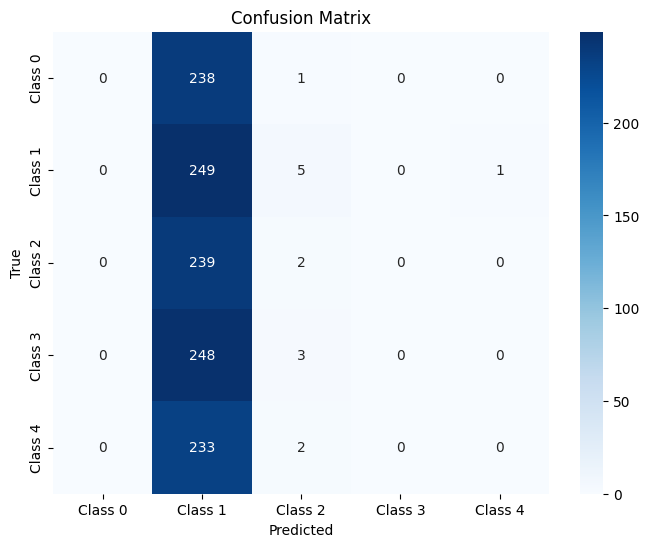

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
PART-2 : A 2-layer RNN architecture (LSTM, using the PyTorch implementations), and a two-layer 
classifier with a ReLU. 

In [56]:
lengths = []
for example in train_dataset:
    for choice in example['choices']['text']:
        combined = example['question'] + choice
        lengths.append(len(combined))

print("Max length:", max(lengths))
print("Average length:", sum(lengths) / len(lengths))


Max length: 68
Average length: 16.433771879647637


In [ ]:
from torch.utils.data import Dataset
import torch

class CommonsenseQARNNDataset(Dataset):
    def __init__(self, dataset, fasttext_model, answer_map={'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}, max_length=32):
        self.dataset = dataset
        self.ft_model = fasttext_model
        self.answer_map = answer_map
        self.max_length = max_length

    def pad_or_truncate(self, tokens):
        if len(tokens) > self.max_length:
            return tokens[:self.max_length]
        else:
            return tokens + ['<PAD>'] * (self.max_length - len(tokens))

    def get_embedding(self, tokens):
        vectors = []
        for token in tokens:
            # Check if the token is in the FastText vocabulary
            if token in self.ft_model.key_to_index:  # `key_to_index` is used for checking vocab
                vectors.append(torch.tensor(self.ft_model[token]))  # Retrieve word vector
            else:
                # If the token is not in vocabulary, use a zero vector
                vectors.append(torch.zeros(300))  # FastText embeddings are of size 300
        return torch.stack(vectors)


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        question = item['question']
        choices = item['choices']['text']
        answer = item['answerKey']

        sequences = []
        for choice in choices:
            combined = question + choice
            emb = self.get_embedding(combined)  # → (max_len, 300)
            sequences.append(emb)

        label = self.answer_map[answer]

        return {'sequences': sequences, 'label': torch.tensor(label, dtype=torch.long)}


In [58]:
def rnn_collate_fn(batch, max_len=22):
    padded_sequences = []
    labels = []

    for sample in batch:
        padded_choices = []
        for seq in sample['sequences']:
            # Truncate sequences that are too long
            if seq.shape[0] > max_len:
                seq = seq[:max_len]
            # Pad sequences that are too short
            elif seq.shape[0] < max_len:
                pad = torch.zeros(max_len - seq.shape[0], 300)
                seq = torch.cat([seq, pad], dim=0)
            padded_choices.append(seq)
        
        # Stack the padded choices for this sample (5, max_len, 300)
        padded_sequences.append(torch.stack(padded_choices))  # (5, max_len, 300)
        labels.append(sample['label'])

    return {
        'sequences': torch.stack(padded_sequences),  # (batch_size, 5, max_len, 300)
        'labels': torch.stack(labels)                # (batch_size,)
    }


In [59]:
train_ds = CommonsenseQARNNDataset(train_dataset, fasttext_model=fasttext_model)
valid_ds = CommonsenseQARNNDataset(valid_dataset, fasttext_model=fasttext_model)
test_ds = CommonsenseQARNNDataset(test_dataset, fasttext_model=fasttext_model)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=rnn_collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=32, collate_fn=rnn_collate_fn)
test_loader = DataLoader(test_ds, batch_size=32, collate_fn=rnn_collate_fn)


In [ ]:
Model Architecture-2

In [ ]:
Preprocessing: Join question + each choice → tokenize → get FastText embeddings → pad sequences.  
Input to Model: Shape (5, seq_len, 300) → 5 tokenized Q+choice pairs per sample.  
Model: Pass through 2-layer LSTM/GRU → extract final hidden state → 2-layer classifier.  
Output: Softmax over logits → probability over 5 choices → predicted label (0–4).

In [60]:
import torch
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim=300, hidden_dim=256, num_layers=2, num_choices=5):
        super(RNNClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_choices = num_choices

        # 2-layer LSTM (as specified)
        self.rnn = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=False
        )

        # 2-layer classifier with ReLU (as specified)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  # 1 logit per choice
        )

    def forward(self, x):
        """Process all 5 choices in parallel maintaining batch structure
        Args:
            x: (batch_size, 5, seq_len, 300)
        Returns:
            logits: (batch_size, 5)
        """
        batch_size = x.size(0)
        
        # Process each choice independently
        choice_logits = []
        for i in range(self.num_choices):
            # Process one choice at a time
            choice_seq = x[:, i, :, :]  # (batch_size, seq_len, 300)
            
            # 2-layer LSTM processing
            _, (hidden, _) = self.rnn(choice_seq)  # hidden: (num_layers, batch_size, hidden_dim)
            final_hidden = hidden[-1]  # (batch_size, hidden_dim)
            
            # 2-layer classifier
            logit = self.classifier(final_hidden)  # (batch_size, 1)
            choice_logits.append(logit)
        
        # Combine all choices
        logits = torch.cat(choice_logits, dim=1)  # (batch_size, 5)
        return logits


In [61]:
import wandb

wandb.init(
    project='CQA_Model-2',
    name='rnn-train-1',
    config={
        'epochs': 3,
        'batch_size': 32,
        'learning_rate': 1e-3,
        'hidden_dim': 256,      # RNN hidden size
        'embedding_dim': 300,   # FastText
        'rnn_layers': 2,
        'rnn_type': 'LSTM',   
        'dropout': 0.3,
        'num_classes': 5
    }
)

accuracy,█▁
epoch,▁▁
loss,▁█
val_accuracy,▁█
val_loss,█▁
accuracy,0.19357
epoch,1
loss,1.60921
val_accuracy,0.205
val_loss,1.60916


In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [63]:
def train_with_wandb_rnn(model, train_loader, val_loader=None, epochs=3):
    model.train()
    device = next(model.parameters()).device
    
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    
    # Add gradient clipping
    max_grad_norm = 1.0
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            inputs = batch['sequences'].to(device)  # (B,5,seq,300)
            labels = batch['labels'].to(device)     # (B,)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)  # (B,5)
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()

            # Metrics
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        # Logging
        avg_loss = total_loss / len(train_loader)
        acc = correct / total
        wandb.log({'train_loss': avg_loss, 'train_acc': acc})
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {acc:.4f}")

        # Validation
        if val_loader:
            validate_with_wandb(model, val_loader, loss_fn)


In [64]:
def validate_with_wandb(model, val_loader, loss_fn):
    model.eval()
    device = next(model.parameters()).device
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['sequences'].to(device)  # (B,5,seq,300)
            labels = batch['labels'].to(device)     # (B,)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

    val_loss = total_loss / len(val_loader)
    val_acc = correct / total
    wandb.log({'val_loss': val_loss, 'val_acc': val_acc})
    print(f"Validation | Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")


In [65]:
# Sample batch verification
for batch in train_loader:
    print(f"Input shape: {batch['sequences'].shape}")  # Should be (B,5,seq_len,300)
    print(f"Label shape: {batch['labels'].shape}")     # Should be (B,)
    break


Input shape: torch.Size([32, 5, 22, 300])
Label shape: torch.Size([32])


In [66]:

model = RNNClassifier().to(device)

train_with_wandb_rnn(model, train_loader, val_loader=valid_loader, epochs=wandb.config.epochs)


Epoch 1/3 | Loss: 1.6091 | Acc: 0.2005
Validation | Loss: 1.6065 | Acc: 0.1940
Epoch 2/3 | Loss: 1.6064 | Acc: 0.2111
Validation | Loss: 1.6093 | Acc: 0.2040
Epoch 3/3 | Loss: 1.6053 | Acc: 0.2124
Validation | Loss: 1.6327 | Acc: 0.2020


In [70]:
def objective(trial):
    # Hyperparameters to tune (expanded for RNN-specific params)
    params = {
        'learning_rate': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64]),
        'hidden_dim': trial.suggest_int('hidden_dim', 128, 512),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'num_layers': trial.suggest_int('num_layers', 1, 3),  # RNN-specific
        'dropout': trial.suggest_float('dropout', 0.1, 0.5)   # RNN-specific
    }
    
    # Initialize W&B
    wandb.init(
        project='CQA_Model-2_Optuna',
        name=f'trial_{trial.number}',
        config={
            **params,
            'epochs': 3,
            'embedding_dim': 300,
            'num_classes': 5,
            'rnn_type': 'LSTM'
        },
        reinit=True
    )
    
    # Create loaders with dynamic batch size
    train_loader = DataLoader(
        train_ds,
        batch_size=params['batch_size'],
        shuffle=True,
        collate_fn=rnn_collate_fn,
        pin_memory=True
    )
    
    valid_loader = DataLoader(
        valid_ds,
        batch_size=params['batch_size'],
        collate_fn=rnn_collate_fn,
        pin_memory=True
    )
    
    # Initialize RNN model with trial parameters
    model = RNNClassifier(
        hidden_dim=params['hidden_dim'],
        num_layers=params['num_layers']
    ).to(device)
    
    # Optimizer with weight decay
    optimizer = optim.Adam(
        model.parameters(),
        lr=params['learning_rate'],
        weight_decay=params['weight_decay']
    )
    loss_fn = nn.CrossEntropyLoss()
    
    best_val_acc = 0
    
    for epoch in range(3):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        
        for batch in train_loader:
            inputs = batch['sequences'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            # Calculate accuracy
            with torch.no_grad():
                _, predicted = outputs.max(dim=1)
                correct = (predicted == labels).sum().item()
            
            train_loss += loss.item()
            train_correct += correct
            train_total += labels.size(0)
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        
        with torch.no_grad():
            for batch in valid_loader:
                inputs = batch['sequences'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                
                # Calculate validation loss
                val_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = outputs.max(dim=1)
                correct = (predicted == labels).sum().item()
                
                val_correct += correct
                val_total += labels.size(0)
        
        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        val_loss = val_loss / len(valid_loader)
        val_acc = val_correct / val_total
        
        # Log metrics
        wandb.log({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        })
        
        print(f"Trial {trial.number} Epoch {epoch+1}/3")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")
        
        # Track best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
    wandb.finish()
    return best_val_acc

# Run study with enhanced settings
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.HyperbandPruner()
)

study.optimize(objective, n_trials=5, gc_after_trial=True)


[I 2025-04-08 05:14:50,794] A new study created in memory with name: no-name-3d940028-fe98-4b6f-9c6f-dc33ca451e16


train_acc,▁▇█
train_loss,█▃▁
val_acc,▁█▇
val_loss,▁▂█
train_acc,0.21245
train_loss,1.6053
val_acc,0.202
val_loss,1.63265


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Trial 0 Epoch 1/3
Train Loss: 1.6094 | Val Loss: 1.6093
Train Acc: 0.1890 | Val Acc: 0.1940
Trial 0 Epoch 2/3
Train Loss: 1.6094 | Val Loss: 1.6093
Train Acc: 0.1964 | Val Acc: 0.2070
Trial 0 Epoch 3/3
Train Loss: 1.6092 | Val Loss: 1.6086
Train Acc: 0.1932 | Val Acc: 0.2080


epoch,▁▅█
train_accuracy,▁█▅
train_loss,▇█▁
val_accuracy,▁▇█
val_loss,█▇▁
epoch,3
train_accuracy,0.19323
train_loss,1.60924
val_accuracy,0.208
val_loss,1.60864


[I 2025-04-08 05:33:03,345] Trial 0 finished with value: 0.208 and parameters: {'lr': 0.0005613400338386438, 'batch_size': 32, 'hidden_dim': 418, 'weight_decay': 9.390485922306709e-05, 'num_layers': 1, 'dropout': 0.3556365484117382}. Best is trial 0 with value: 0.208.


Trial 1 Epoch 1/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.2008 | Val Acc: 0.2130
Trial 1 Epoch 2/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1851 | Val Acc: 0.2000
Trial 1 Epoch 3/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1811 | Val Acc: 0.1950


epoch,▁▅█
train_accuracy,█▂▁
train_loss,█▆▁
val_accuracy,█▃▁
val_loss,█▃▁
epoch,3
train_accuracy,0.1811
train_loss,1.60944
val_accuracy,0.195
val_loss,1.60944


[I 2025-04-08 05:52:10,179] Trial 1 finished with value: 0.213 and parameters: {'lr': 8.36639865019827e-05, 'batch_size': 32, 'hidden_dim': 470, 'weight_decay': 0.0002745372409990082, 'num_layers': 3, 'dropout': 0.4584721764825156}. Best is trial 1 with value: 0.213.


Trial 2 Epoch 1/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1967 | Val Acc: 0.2000
Trial 2 Epoch 2/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1955 | Val Acc: 0.2000
Trial 2 Epoch 3/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1955 | Val Acc: 0.2000


epoch,▁▅█
train_accuracy,█▁▁
train_loss,█▁▁
val_accuracy,▁▁▁
val_loss,▁▁▁
epoch,3
train_accuracy,0.19552
train_loss,1.60944
val_accuracy,0.2
val_loss,1.60944


[I 2025-04-08 06:00:52,262] Trial 2 finished with value: 0.2 and parameters: {'lr': 0.0030563422234351208, 'batch_size': 64, 'hidden_dim': 432, 'weight_decay': 4.6414472155966004e-05, 'num_layers': 3, 'dropout': 0.15669818225254933}. Best is trial 1 with value: 0.213.


Trial 3 Epoch 1/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1912 | Val Acc: 0.1960
Trial 3 Epoch 2/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1922 | Val Acc: 0.1940
Trial 3 Epoch 3/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1964 | Val Acc: 0.2000


epoch,▁▅█
train_accuracy,▁▂█
train_loss,▁██
val_accuracy,▃▁█
val_loss,▁██
epoch,3
train_accuracy,0.19643
train_loss,1.60944
val_accuracy,0.2
val_loss,1.60944


[I 2025-04-08 06:25:07,330] Trial 3 finished with value: 0.2 and parameters: {'lr': 0.00011086744664184443, 'batch_size': 16, 'hidden_dim': 509, 'weight_decay': 0.00011796802453665688, 'num_layers': 2, 'dropout': 0.1028411692852132}. Best is trial 1 with value: 0.213.


Trial 4 Epoch 1/3
Train Loss: 1.6095 | Val Loss: 1.6094
Train Acc: 0.1865 | Val Acc: 0.2000
Trial 4 Epoch 2/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1955 | Val Acc: 0.2000
Trial 4 Epoch 3/3
Train Loss: 1.6094 | Val Loss: 1.6094
Train Acc: 0.1955 | Val Acc: 0.2000


epoch,▁▅█
train_accuracy,▁██
train_loss,█▁▁
val_accuracy,▁▁▁
val_loss,▁▁▁
epoch,3
train_accuracy,0.19552
train_loss,1.60944
val_accuracy,0.2
val_loss,1.60944


[I 2025-04-08 06:42:21,744] Trial 4 finished with value: 0.2 and parameters: {'lr': 0.009902189877236867, 'batch_size': 32, 'hidden_dim': 226, 'weight_decay': 6.492456899040013e-05, 'num_layers': 2, 'dropout': 0.19361228753817794}. Best is trial 1 with value: 0.213.


In [74]:
best_params

{'lr': 8.36639865019827e-05,
 'batch_size': 32,
 'hidden_dim': 470,
 'weight_decay': 0.0002745372409990082,
 'num_layers': 3,
 'dropout': 0.4584721764825156}

In [76]:
# Train final model with best params (ARCH 2)
best_params = study.best_params

wandb.init(
    project='CQA_Model-2_Final',
    config={
        **best_params,
        'epochs': 3,
        'embedding_dim': 300,
        'num_classes': 5
    },
    name='arch2_final_run'
)

# Initialize final model with best params
final_model = RNNClassifier(
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers']
).to(device)

# Use entire training data (train + valid)
full_train_dataset = torch.utils.data.ConcatDataset([train_ds, valid_ds])
full_train_loader = DataLoader(
    full_train_dataset,
    batch_size=best_params['batch_size'],
    shuffle=True,
    collate_fn=rnn_collate_fn,
    pin_memory=True
)

# Optimizer with best params
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['lr'],
    weight_decay=best_params['weight_decay']
)

# Train with existing function (modified for full dataset)
def train_with_wandb_rnn_final(model, train_loader, epochs=3):
    model.train()
    device = next(model.parameters()).device
    
    loss_fn = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            inputs = batch['sequences'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            
            loss.backward()
            optimizer.step()

            # Metrics
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        # Logging
        avg_loss = total_loss / len(train_loader)
        acc = correct / total
        wandb.log({
            'epoch': epoch+1,
            'train_loss': avg_loss,
            'train_acc': acc
        })
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Acc: {acc:.4f}")

train_with_wandb_rnn_final(final_model, full_train_loader, epochs=3)
wandb.finish()

Epoch 1/3 | Loss: 1.6094 | Acc: 0.1892
Epoch 2/3 | Loss: 1.6094 | Acc: 0.1861
Epoch 3/3 | Loss: 1.6094 | Acc: 0.1885


epoch,▁▅█
train_acc,█▁▆
train_loss,█▆▁
epoch,3
train_acc,0.18848
train_loss,1.60944


In [79]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Initialize W&B for logging
wandb.init(
    project='CQA_Model-2_Evaluation',
    config={
        'model_type': 'RNN',
        'test_batch_size': 32,
        'embedding_dim': 300,
        'num_classes': 5
    },
    name='arch2_final_evaluation'
)

# Prediction on test set
final_model.eval()
y_true = []
y_pred = []
final_model.to(device)

with torch.no_grad():
    for batch in test_loader:
        inputs = batch['sequences'].to(device)
        targets = batch['labels'].to(device)
        
        outputs = final_model(inputs)
        _, predicted = outputs.max(dim=1)
        
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')

# Log to W&B
wandb.log({
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
})

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Close W&B run
wandb.finish()


Test Accuracy: 0.1908
Precision: 0.1807
Recall: 0.1937
F1 Score: 0.0991


accuracy,▁
f1,▁
precision,▁
recall,▁
accuracy,0.19083
f1,0.09911
precision,0.18072
recall,0.19373


In [80]:
misclassified = []
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['sequences'].to(device)
        targets = batch['labels'].to(device)
        
        outputs = final_model(inputs)
        _, predicted = outputs.max(dim=1)
        
        incorrect_indices = (predicted != targets).nonzero(as_tuple=True)[0]
        
        for idx in incorrect_indices:
            misclassified.append((
                inputs[idx].cpu().numpy(),  # Full sequence (5,seq,300)
                targets[idx].cpu().numpy(),
                predicted[idx].cpu().numpy()
            ))


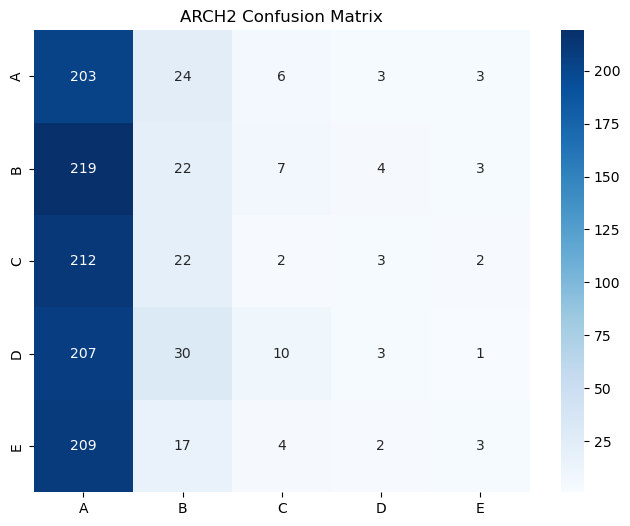

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['A','B','C','D','E'],
            yticklabels=['A','B','C','D','E'])
plt.title('ARCH2 Confusion Matrix')
plt.show()


In [ ]:
INTERPRETATION-

In [ ]:
CONCLUSION